# Implementing Convolutional Neural Network

In [1]:
## Import all the required libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import random_split,DataLoader,Subset
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor,Normalize
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

In [2]:
# Define one-hot encoding function
def one_hot_encoding(labels, num_classes=10):
    encoded_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):
        encoded_labels[i][labels[i]] = 1
    return encoded_labels


# Load MNIST dataset
mnist_dataset = datasets.MNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transforms.ToTensor()
)

# Total number of samples
total_samples = len(mnist_dataset)

indices = list(range(total_samples))

# Create training, validation, and testing samples of the required size
train_indices = indices[:5000]
val_indices = indices[5000:6000]
test_indices = indices[6000:8000]

train_dataset = Subset(mnist_dataset, train_indices)
val_dataset = Subset(mnist_dataset, val_indices)
test_dataset = Subset(mnist_dataset, test_indices)

# One-hot encode the labels and convert them to PyTorch tensors
train_labels = torch.tensor(one_hot_encoding([mnist_dataset.targets[i] for i in train_indices]))
val_labels = torch.tensor(one_hot_encoding([mnist_dataset.targets[i] for i in val_indices]))
test_labels = torch.tensor(one_hot_encoding([mnist_dataset.targets[i] for i in test_indices]))

# Modify train_dataset, val_dataset, and test_dataset to include one-hot encoded labels
for i, idx in enumerate(train_indices):
    train_dataset.dataset.targets[idx] = train_labels[i].argmax().item()

for i, idx in enumerate(val_indices):
    val_dataset.dataset.targets[idx] = val_labels[i].argmax().item()

for i, idx in enumerate(test_indices):
    test_dataset.dataset.targets[idx] = test_labels[i].argmax().item()

# Batch size
batch_size = 100

# Finally, load the datasets using DataLoader with a batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Implementing Network - A (Convolutional Neural Network)

In [3]:
class Network_A(nn.Module):
    
    def __init__(self): 
        super(Network_A, self).__init__()  # Add this line to properly initialize the base class
        self.conv1 = nn.Conv2d(1, 16 , 5 , stride=1)
        self.conv2 = nn.Conv2d(16 , 32 , 5 , stride=1)
        self.pool = nn.MaxPool2d(2 , 2)
        self.fc1 = nn.Linear(3200 , 512)
        self.fc2 = nn.Linear(512 , 128)
        self.fc3 = nn.Linear(128 , 10)
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor for fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.softmax(x, dim=1)  # Applying softmax activation after fc3
        
        return x       

## Implementing Network - 2 (Convolutional Neural Network)

In [4]:
class Network_B(nn.Module):
    
    def __init__(self): 
        super(Network_B, self).__init__()  # Add this line to properly initialize the base class
        self.conv1 = nn.Conv2d(1, 16 , 5 , stride=1)
        self.conv2 = nn.Conv2d(16 , 32 , 5 , stride=1)
        self.pool = nn.MaxPool2d(2 , 2)
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer with dropout probability of 0.5
        self.fc1 = nn.Linear(3200 , 512)
        self.dropout2 = nn.Dropout(0.5)  # Dropout layer with dropout probability of 0.5
        self.fc2 = nn.Linear(512 , 128)
        self.fc3 = nn.Linear(128 , 10)
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # Flatten the tensor for fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.softmax(x, dim=1)  # Applying softmax activation after fc3
        
        return x 

## Implementing Network - B (Feed Forward Neural Network)

In [5]:
class Artificial_NN_B(nn.Module):
    
    def __init__(self):
        super(Artificial_NN_B, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_layers = nn.Sequential(
            nn.Linear(784,150),
            nn.ReLU(),
            nn.Linear(150,150),
            nn.ReLU(),
            nn.Linear(150,10)  
        )
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, input_d):
        input_outcome = self.flatten(input_d)
        hidden_outcome = self.hidden_layers(input_outcome)
        final_predictions = self.softmax(hidden_outcome)
        return final_predictions

## Calculating Accuracy

In [6]:
def calculate_accuracy(model, dataloader):    
    accuracy = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            accuracy = correct / total
    return accuracy

## Training

In [7]:
def Train_Network(num_of_epochs,full_train_dataloader,full_val_dataloader,weight_decay_value,learning_rate,choose_model):
    
    if(choose_model == 0):
        model = Network_A()
    elif(choose_model == 1):
        model = Network_B()
    elif(choose_model == 2):
        model = Artificial_NN_B()
    
    # choosing the cross-entropy loss
    loss_fn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)
    
    train_losses = []  # List to store training losses for plotting
    val_losses = []    # List to store validation losses for plotting
    train_accuracies = []  # List to store training accuracies for plotting
    val_accuracies = []    # List to store validation accuracies for plotting

    ## Epoch loop for calculating accuracy with pytorch ADAM optimizer
    
    for epoch in range(num_of_epochs):
        
        model.train()
        
        calc_loss = 0;
        
        for idx,(inputs,labels) in enumerate (full_train_dataloader):
            
            optimizer.zero_grad()
            
            predictions = model(inputs)   # make predictions
            
            calc_loss = loss_fn(predictions, labels)  # calculate loss
            
            # Backprop
            calc_loss.backward()
            
            # update all the parameters
            optimizer.step()
            
         # Print training and validation losses
        if (epoch != 0) and (epoch % 50 == 0):
            print(f'Epoch {epoch}, loss: {calc_loss}')
                
        train_losses.append(calc_loss.detach().numpy())
                      
        model.eval()
        
        train_accuracy = calculate_accuracy(model, full_train_dataloader)
        train_accuracies.append(train_accuracy)
        
        val_accuracy = calculate_accuracy(model, full_val_dataloader)
        val_accuracies.append(val_accuracy)
    
    
    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_of_epochs),train_losses,label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average cross entropy loss')
    plt.title('Average cross entropy loss vs Epoch')
    plt.legend()
    plt.show()
            
            
    return model ,  train_accuracies , val_accuracies

## Train and Evalute Network A with (learning rate: 5 × 10-2, weight decay: 1 × 10-3)

Epoch 50, loss: 2.3511505126953125
Epoch 100, loss: 2.3511507511138916


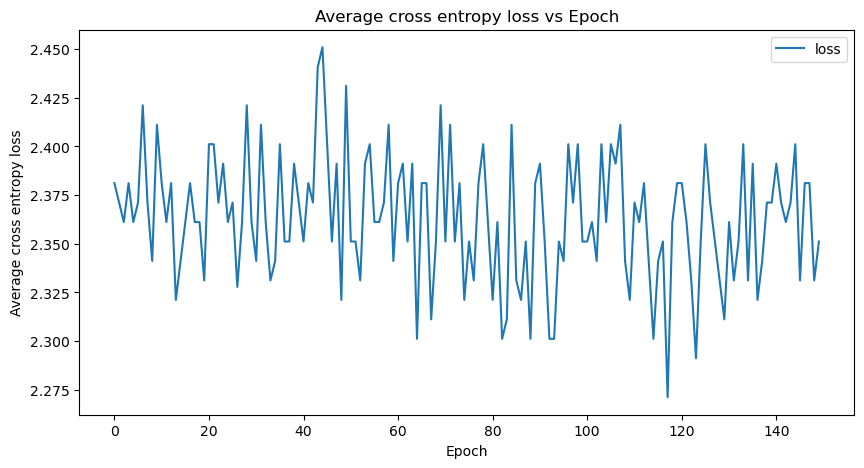

In [8]:
 trained_model_A_1,train_accuracy_A_1 , val_accuracy_A_1 = Train_Network(150,train_loader,val_loader,10**-3,5*(10**-2),0)

In [9]:
# Train Accuracy at last epoch
train_accuracy_A_1[-1]

0.11

In [10]:
# validation Accuracy at last epoch
val_accuracy_A_1[-1]

0.11

In [11]:
# Test accuracy
accuracy_A_1 = calculate_accuracy(trained_model_A_1, test_loader)
print(accuracy_A_1)

0.1


## Train and Evalute Network A with (learning rate: 1 × 10^-4, weight decay: 1 × 10^-5)

Epoch 50, loss: 1.4928516149520874
Epoch 100, loss: 1.471055030822754


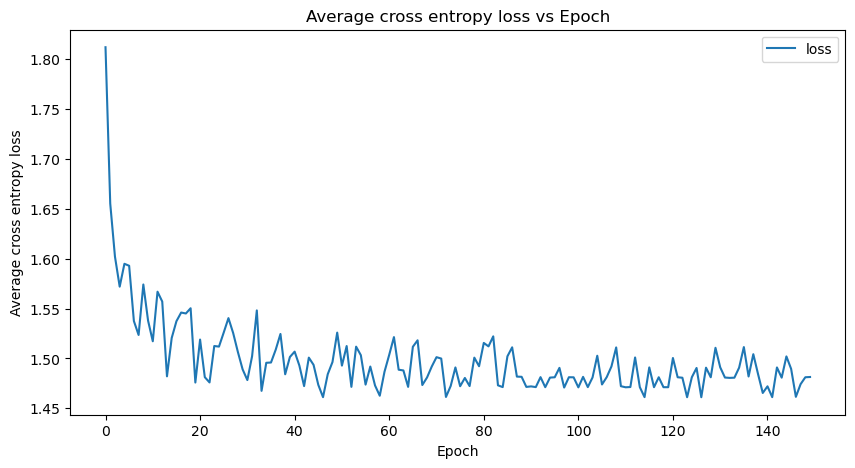

In [12]:
 trained_model_A_2 , train_accuracy_A_2 , val_accuracy_A_2  = Train_Network(150,train_loader,val_loader,10**(-5),10**(-4),0)

In [13]:
# Train Accuracy at last epoch
train_accuracy_A_2[-1]

1.0

In [14]:
# validation Accuracy at last epoch
val_accuracy_A_2[-1]

0.98

In [15]:
# Test accuracy
accuracy_A_2 = calculate_accuracy(trained_model_A_2, test_loader)
print(accuracy_A_2)

0.93


## Train and Evalute Network B with (learning rate: 5 × 10^-2, weight decay: 1 × 10^-3)

Epoch 50, loss: 2.3611507415771484
Epoch 100, loss: 2.3411507606506348


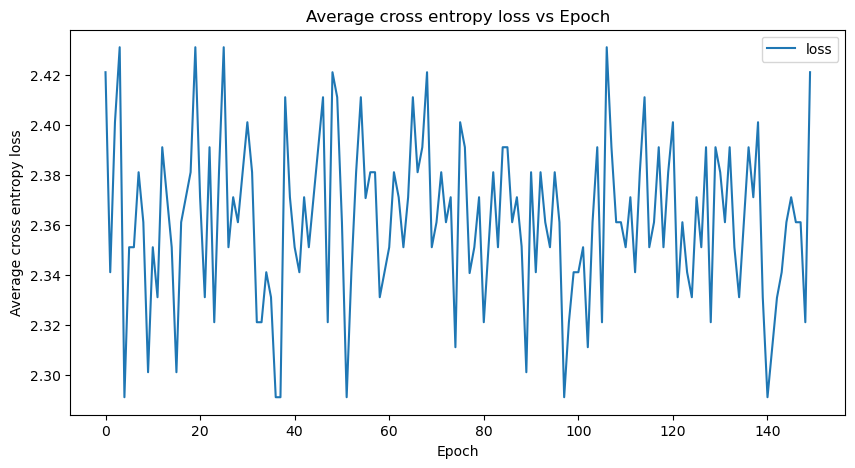

In [16]:
 trained_model_B_1,train_accuracy_B_1 , val_accuracy_B_1 = Train_Network(150,train_loader,val_loader,10**-3,5*(10**-2),1)

In [17]:
# Train Accuracy at last epoch
train_accuracy_B_1[-1]

0.12

In [18]:
# validation Accuracy at last epoch
val_accuracy_B_1[-1]

0.11

In [19]:
# Test Accuracy
accuracy_B_1 = calculate_accuracy(trained_model_B_1, test_loader)
print(accuracy_B_1)

0.1


## Train and Evalute Network B with (learning rate: 1 × 10^-4, weight decay: 1 × 10^-5)

Epoch 50, loss: 1.471096158027649
Epoch 100, loss: 1.4713661670684814


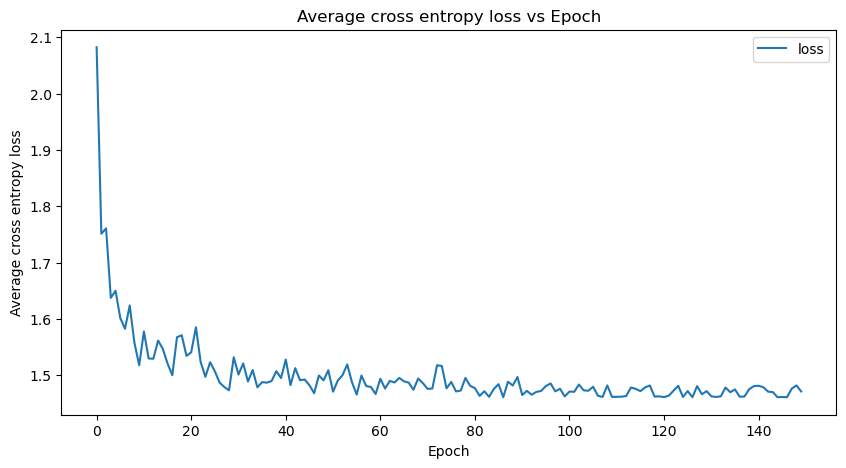

In [20]:
trained_model_B_2,train_accuracy_B_2 , val_accuracy_B_2 = Train_Network(150,train_loader,val_loader,10**(-5),10**(-4),1)

In [21]:
# Train Accuracy at last epoch
train_accuracy_B_2[-1]

1.0

In [22]:
# validation Accuracy at last epoch
val_accuracy_B_2[-1]

1.0

In [23]:
# Test accuracy
accuracy_B_2 = calculate_accuracy(trained_model_B_2, test_loader)
print(accuracy_B_2)

0.99


## Training and evaluting Network - B from Hands on 2 

Epoch 50, loss: 1.558969259262085
Epoch 100, loss: 1.487776756286621


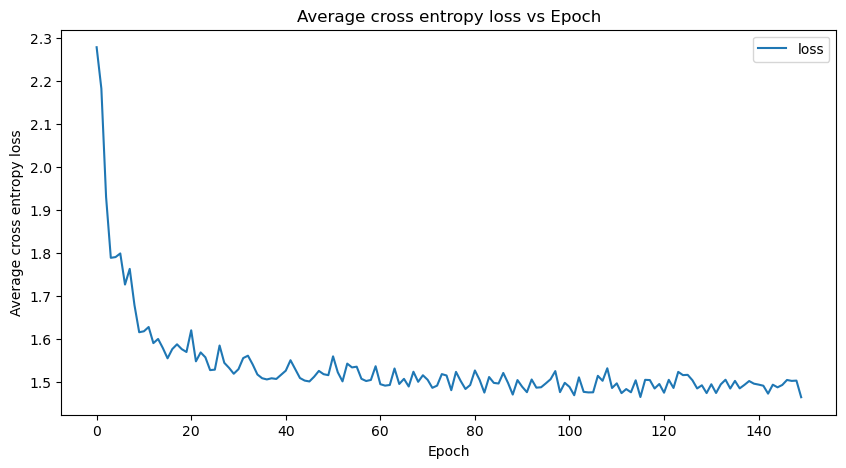

In [24]:
trained_model_3, train_accuracy_3 , val_accuracy_3 = Train_Network(150,train_loader,val_loader,10**(-5),10**(-4),2)

In [25]:
# Train Accuracy at last epoch
train_accuracy_3[-1]

0.97

In [26]:
# validation Accuracy at last epoch
val_accuracy_3[-1]

0.95

In [27]:
# Test accuracy
accuracy_3 = calculate_accuracy(trained_model_B_2, test_loader)
print(accuracy_3)

0.99


In [28]:
''' If we compare the network B of CNN with the Network B of FNN (from hands on 2) ... we can see that the test of both these
methods is 0.99 that is 99 percent but the validation accuracy in case of CNN is 100 percent , on the other hand validation 
accuracy of FNN is 95 percent so we can conclude that CNN is performing better than FNN'''

## Calculation of parameters